In [13]:
import matplotlib.pyplot as plt
# import PyPDF2
from pdf2image import convert_from_path

In [14]:
def display(img):
  # for i, page_img in enumerate(pages):
  plt.figure(figsize=(8, 10))
  plt.imshow(img)
  plt.axis('off')
  plt.show()



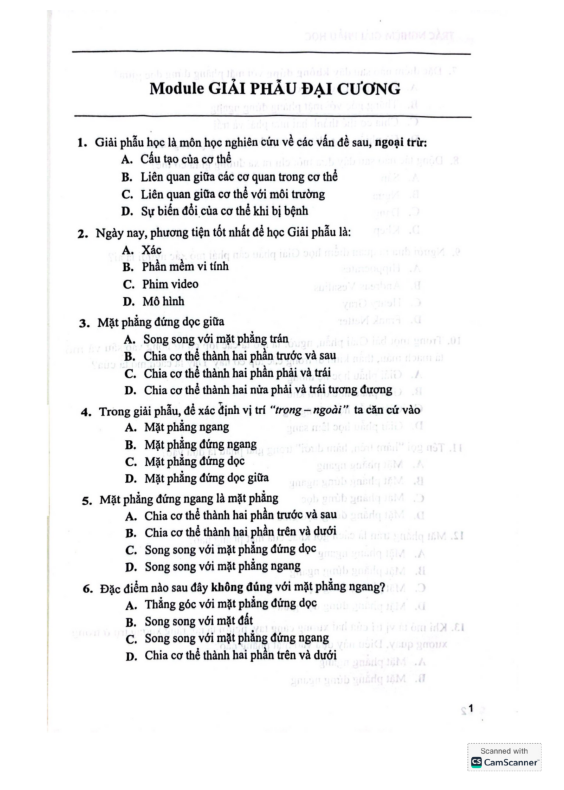

In [15]:
pdf_path = "Module GPDC-2.pdf"
pages = convert_from_path(pdf_path)
display(pages[0])


In [16]:
import numpy as np
import cv2

temp_img = pages[0]
temp_img_2 = pages[1]

first_page = np.array(temp_img)
second_page = np.array(temp_img_2)
print(type(first_page))

<class 'numpy.ndarray'>


# Crop the header

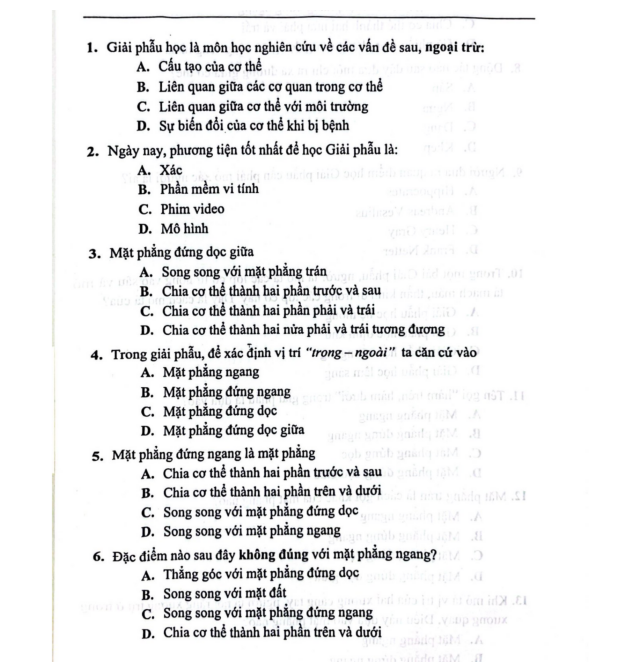

In [17]:
# first_page is a NumPy array representing the image
header_height = 300  # pixels to remove from the top
footer_height = 300  # pixels to remove from the bottom

first_page = first_page[header_height:-footer_height, :, :]
display(first_page)

# Crop the second page

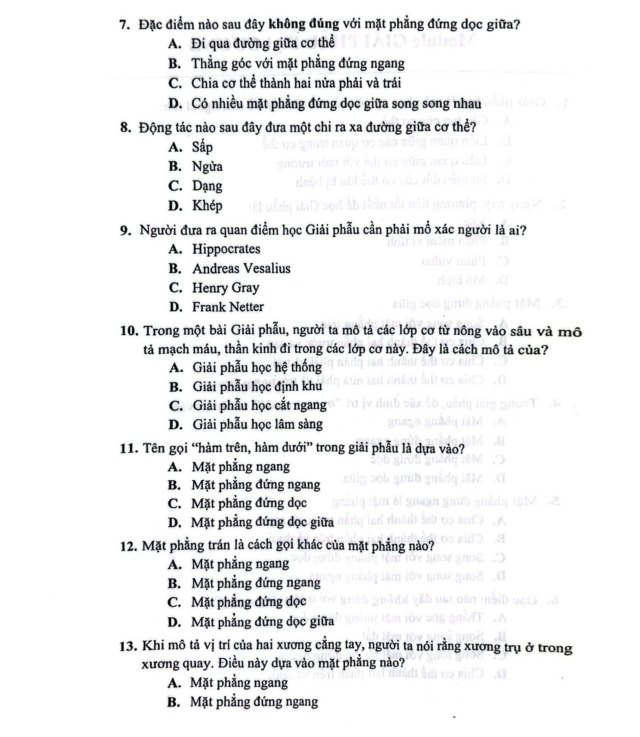

In [18]:
# first_page is a NumPy array representing the image
header_height = 175  # pixels to remove from the top
footer_height = 250  # pixels to remove from the bottom

second_page = second_page[header_height:-footer_height, :, :]
display(second_page)

# Dilation and Threshold

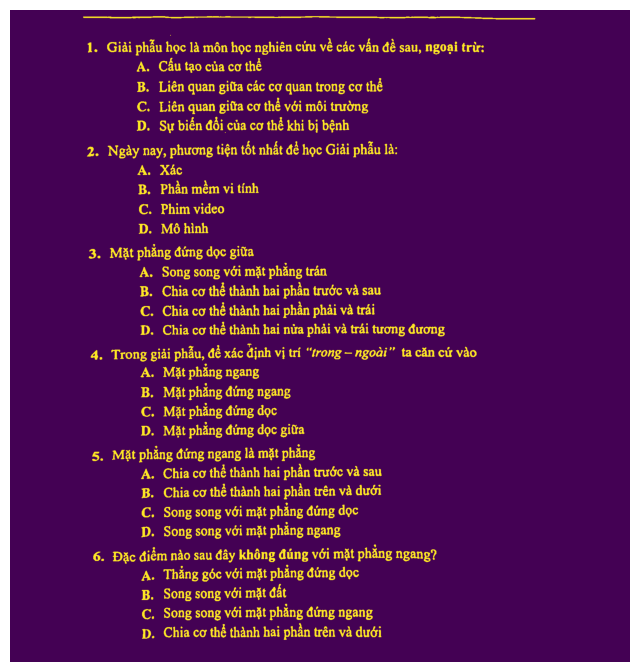

In [19]:
gray = cv2.cvtColor(first_page, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

display(thresh)

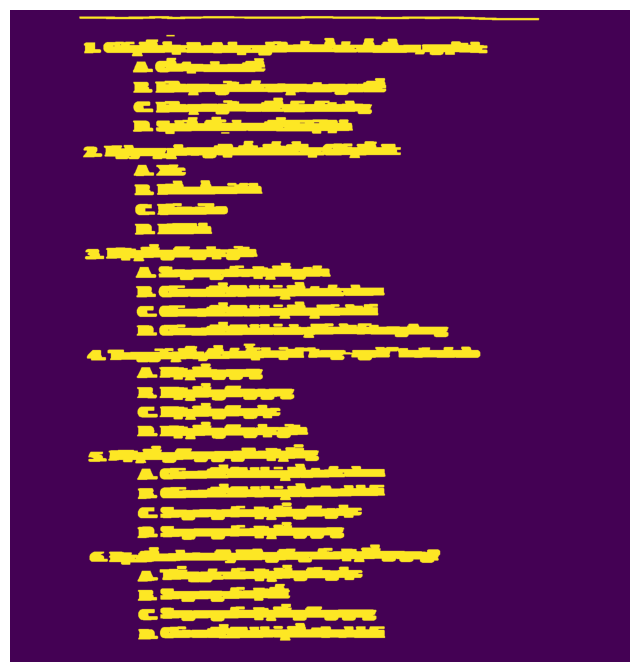

In [20]:
# 3. Dilation
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 2))
dilate = cv2.dilate(thresh, kernel, iterations=2)
display(dilate)


In [21]:
contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
blocks = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if h > 29 and w > 60: 
        roi = first_page[y:y+h, x:x+w]
        blocks.append((y, roi))

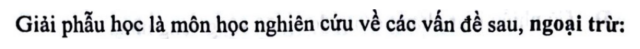

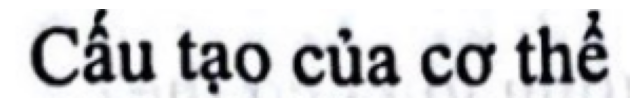

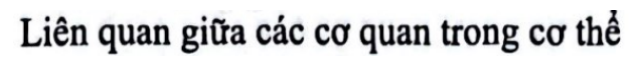

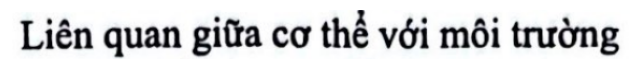

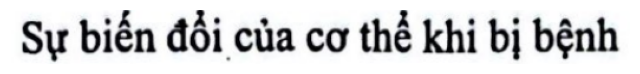

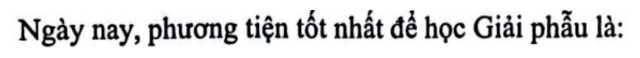

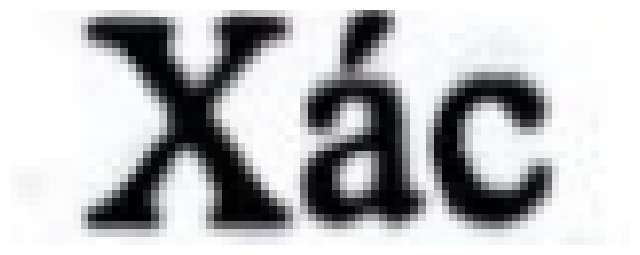

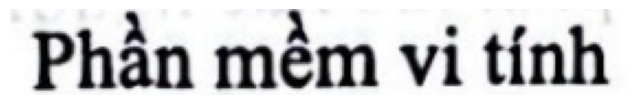

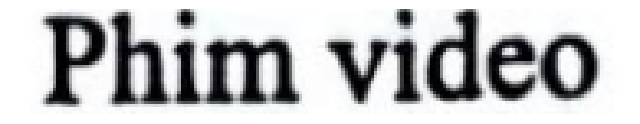

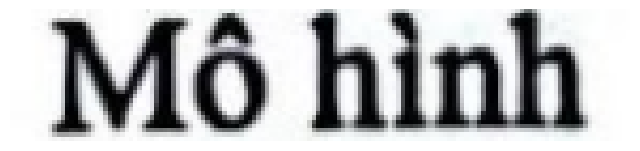

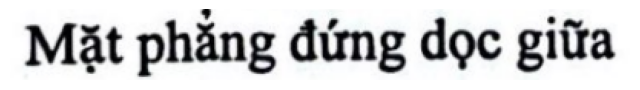

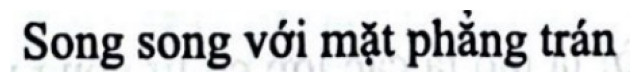

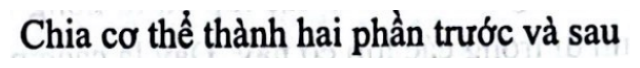

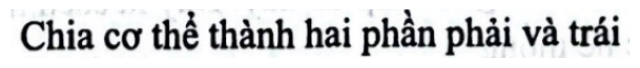

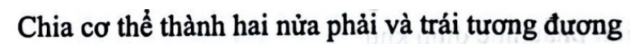

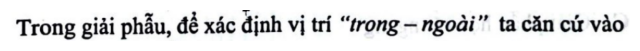

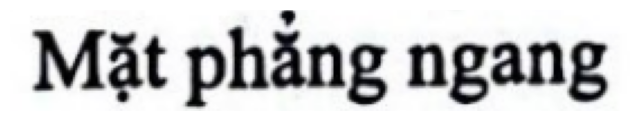

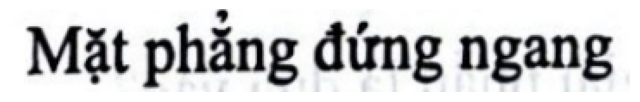

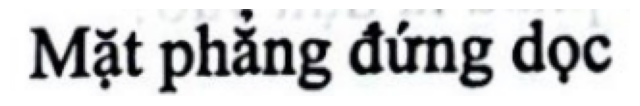

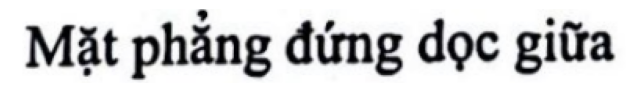

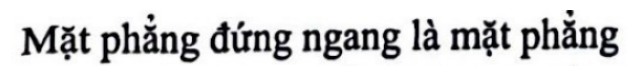

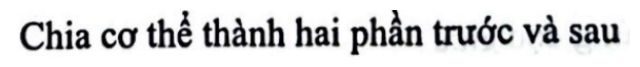

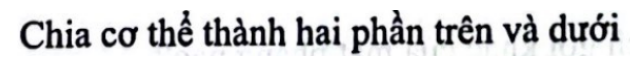

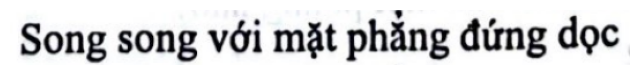

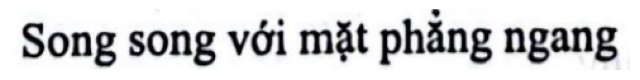

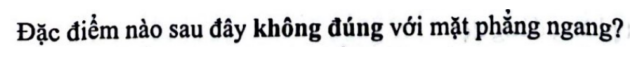

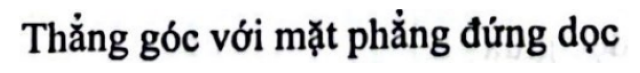

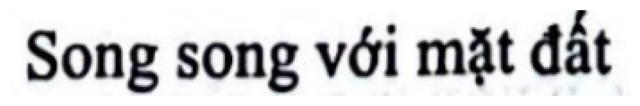

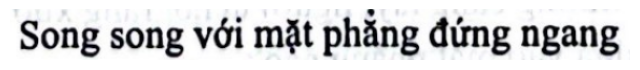

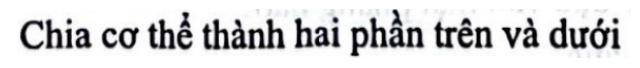

In [22]:
blocks = sorted(blocks, key=lambda b: b[0])
for _, roi in blocks:
  display(roi)

# OCR processing

In [23]:
import pytesseract
from pprint import pprint
config = "--oem 1 --psm 7 -l vie"

data = []

for _, roi in blocks:
    roi = cv2.resize(roi, None, fx=4, fy=4, interpolation=cv2.INTER_LANCZOS4)
    text = pytesseract.image_to_string(roi, config=config)
    text = text.replace("\n", " ")
    data.append(text)

pprint(data)

# _, roi = blocks[9]
# roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
# roi = cv2.resize(roi, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
# display(roi)
# text = pytesseract.image_to_string(roi, config=config)
# print(text)


['Giải phẫu học là môn học nghiên cứu vê các vẫn đề sau, ngoại trừ: ',
 'Câu tạo của cơ thê ',
 'Liên quan giữa các cơ quan trong cơ thê ',
 'Liên quan giữa cơ thê với môi trường ',
 'Sự biên đôi của cơ thê khi bị bệnh ',
 'Ngày nay, phương tiện tốt nhất để học Giải phẫu là: ',
 'Xác ',
 'Phân mêm vi tính ',
 'Phim video ',
 'Mô hình ',
 'Mặt phăng đứng dọc giữa ',
 'Song song với mặt phăng trán ',
 'Chia cơ thể thành hai phân trước và sau ',
 'Chia cơ thể thành hai phân phải và trái ',
 'Chia cơ thê thành hai nửa phải và trái tương đương ',
 'Trong giải phẫu, đề xác định vị trí “rong — ngoài” ta căn cứ vào ',
 'Mặt phăng ngang ',
 'Mặt phăng đứng ngang ',
 'Mặt phăng đứng dọc ',
 'Mặt phăng đứng dọc giữa ',
 'Mặt phẳng đứng ngang là mặt phăng ',
 'Chia cơ thê thành hai phân trước và sau ',
 'Chia cơ thê thành hai phân trên và dưới ',
 'Song song với mặt phăng đứng dọc ',
 'Song song với mặt phăng ngang ',
 'Đặc điểm nào sau đây không đúng với mặt phăng ngang? ',
 'Thắng góc với mặt ph

# Save in structure Fields

In [26]:
import json

questions = []

i = 0
while i < len(data):
    question_text = data[i].strip()
    if i + 4 <= len(data):
        options = data[i+1:i+5]
        struct = {
            "Question": question_text,
            "A": options[0].strip(),
            "B": options[1].strip(),
            "C": options[2].strip(),
            "D": options[3].strip()
        }
        questions.append(struct)
        i += 5  
    else:
        break

with open("questions.json", "w", encoding="utf-8") as f:
    json.dump(questions, f, ensure_ascii=False, indent=2)

print("✅ Saved in questions.json")

✅ Saved in questions.json


# Altering Coordinates

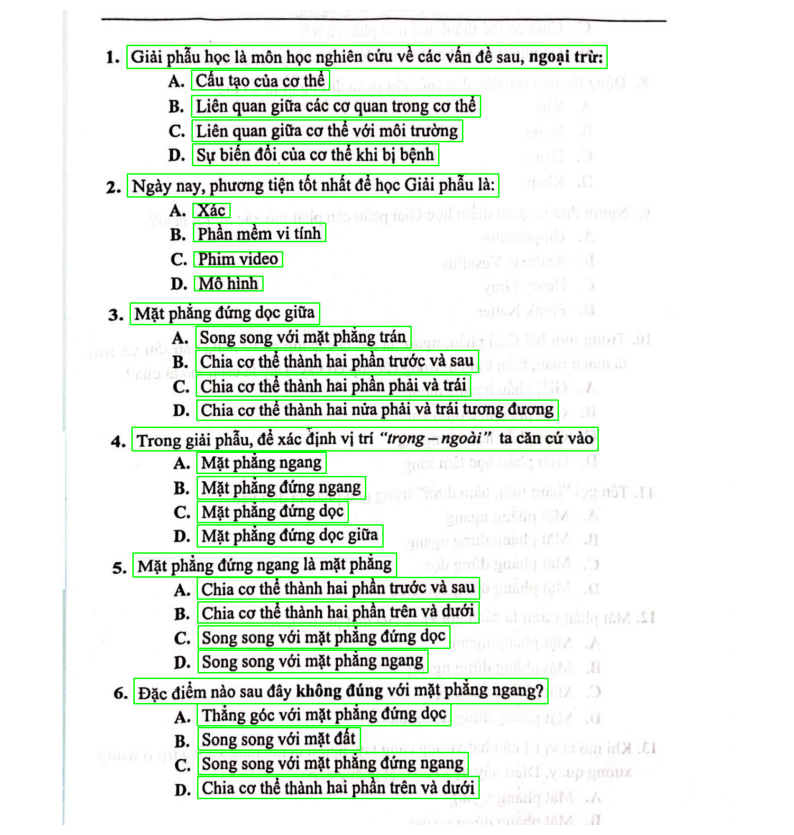

In [24]:
img_bbox = first_page.copy()

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if h > 29 and w > 60:   # lọc noise
      cv2.rectangle(img_bbox, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(10, 12))
plt.imshow(cv2.cvtColor(img_bbox, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()